In [4]:
import pandas as pd
import geopandas as gpd
from glob import glob
import folium
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

top_sub_path = sorted(glob("../data/raw/top_rent_suburbs_*.csv"))[-1]
top_sub = pd.read_csv(top_sub_path)
top_sub['value_'] = top_sub['value'].copy()
top_sub['value'] = top_sub['value'].str.replace('\$|,','').astype(int)
# scraping results can be downloaded, or obtained and preprocessed through scrape_house_speakingsame_buy|rent.py and preprocess_house_speakingsame.py

# Terry -
#rawdf = pd.read_csv(sorted(glob('../data/curated/housespeakingsame/*.csv'))[-1], parse_dates=['rent_date', 'sold_date', 'last_sold_date'])

# Arjun -
rawdf = pd.read_csv(sorted(glob('../data/curated/*.csv'))[-1], parse_dates=['rent_date', 'sold_date', 'last_sold_date'])

prox = pd.read_csv(sorted(glob('../data/raw/ORS/sthcrs_*.csv'))[-1], index_col=[0])
prox_lf = rawdf.dropna(subset=['lng','lat']).drop_duplicates(subset=['lng','lat'])[['lng','lat']].copy()
prox_lf[['duration', 'distance']] = prox[['duration','distance']].values.tolist()
rawdf = rawdf.merge(prox_lf, on=['lng','lat'])

/tmp/ipykernel_620/2895260077.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  top_sub['value'] = top_sub['value'].str.replace('\$|,','').astype(int)
/tmp/ipykernel_620/2895260077.py:19: DtypeWarning: Columns (5,6,7,10,11,16,18,33) have mixed types. Specify dtype option on import or set low_memory=False.
  rawdf = pd.read_csv(sorted(glob('../data/curated/*.csv'))[-1], parse_dates=['rent_date', 'sold_date', 'last_sold_date'])


# Outlier Detection

In [5]:
df = rawdf[['property_type','agent','source','suburb','land_size', 'duration', 'distance',
            'building_size','bed','bath','car','rent_price','rent_date','sold_price','sold_date','last_sold_price','last_sold_date']].copy()
df[['bed','bath','car']] = df[['bed','bath','car']].fillna(0)

In [6]:
# z-scores
cols = ['land_size','building_size','bed','bath','car','rent_price','sold_price','last_sold_price']
for col in cols:
    z = (df[col] - df[col].mean()) / df[col].std()
    df[col+'_out'] = z>3
df['outlier'] = df[[col+'_out' for col in cols]].any(axis=1)

In [7]:
clean_df = df.loc[~df['outlier']].drop([col+'_out' for col in cols] + ['outlier'],axis=1)
clean_df = clean_df.query("rent_price<7000")

# Data

A total of ~80K properties are scraped from the top 200 suburbs by rent value.

These 200 suburbs are discretised into 5 bins. Since the top 2 suburbs are ski resorts with abnormally high rent values, they are assigned their own category manually, then 4 equal width bins are assigned to the remaining 198 suburbs.

In [8]:
top200 = top_sub.head(200).copy()
top200['suburb_category'] = ['vhigh', 'vhigh'] + pd.cut(top200['value'].values[2:], 4, labels=['vlow','low','mid','high']).tolist()
top200['suburb_category'] = pd.Categorical(top200['suburb_category'], categories=['vlow','low','mid','high','vhigh'], ordered=True)

In [9]:
clean_df['suburb_category'] = clean_df['suburb'].map(top200.set_index('suburb')['suburb_category'].to_dict())

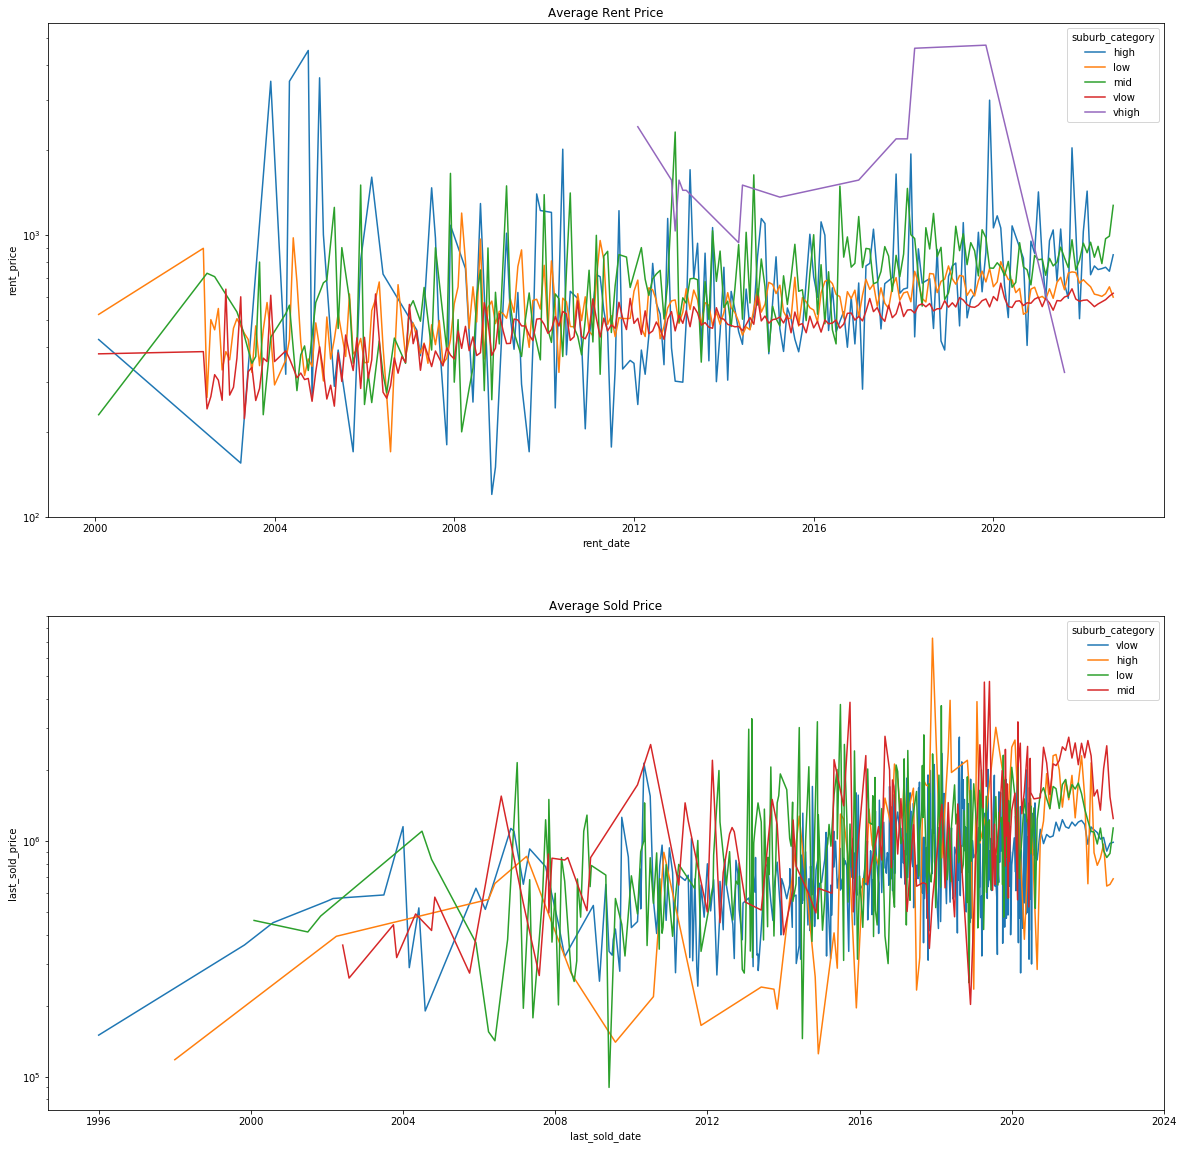

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
sns.lineplot(data=clean_df.groupby(['rent_date','suburb_category'])['rent_price'].mean().reset_index().sort_values("rent_date"), 
             x='rent_date', y='rent_price', hue='suburb_category', ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Average Rent Price')
sns.lineplot(data=clean_df.groupby(['last_sold_date','suburb_category'])['last_sold_price'].mean().reset_index().sort_values("last_sold_date"), 
             x='last_sold_date', y='last_sold_price', hue='suburb_category', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Average Sold Price')
fig.savefig("../plots/avg_sub_cat_price.png")

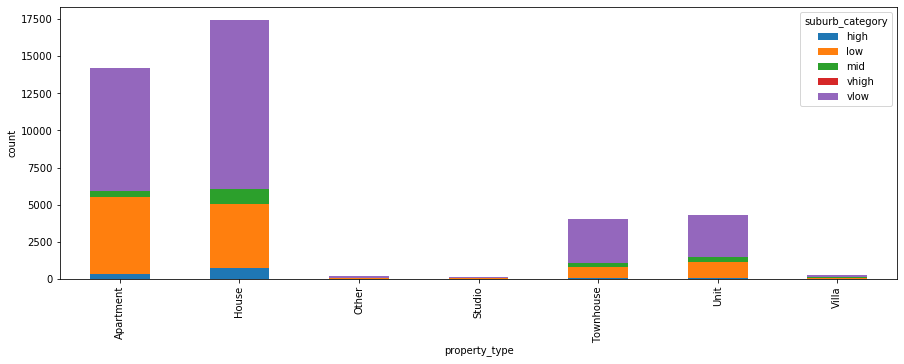

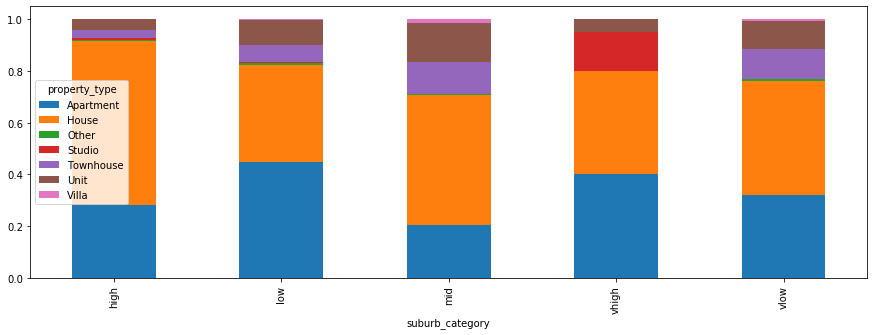

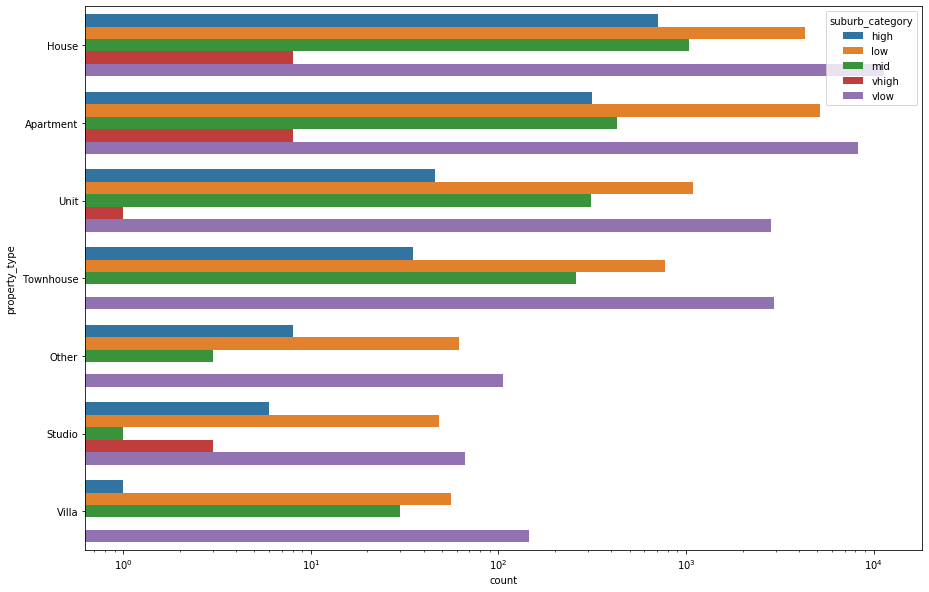

In [11]:
prop_types = clean_df['property_type'].value_counts().loc[clean_df['property_type'].value_counts()>100].index
cat_nprop_map = clean_df.loc[clean_df['property_type'].isin(prop_types)].groupby('suburb_category')['property_type'].count().to_dict()
sub_prop_type_df = clean_df.loc[clean_df['property_type'].isin(prop_types)].groupby('suburb_category')['property_type'].value_counts().reset_index(name='count')
sub_prop_type_df['nprop'] = sub_prop_type_df['suburb_category'].map(cat_nprop_map)
sub_prop_type_df['prop'] = sub_prop_type_df['count'] / sub_prop_type_df['nprop']

fig, ax = plt.subplots(1,1,figsize=(15,5))
sub_prop_type_df.pivot('property_type','suburb_category','count').fillna(0).plot(kind='bar', stacked=True, ax=ax)
plt.ylabel('count')
plt.show()
fig.savefig("../plots/sub_cat_property_type_counts.png")
    
fig, ax = plt.subplots(1,1,figsize=(15,5))
sub_prop_type_df.pivot('property_type','suburb_category','prop').fillna(0).T.plot(kind='bar', stacked=True, ax=ax)
plt.show()
fig.savefig("../plots/sub_cat_property_type_prop.png")

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(data=sub_prop_type_df, x='count', y='property_type', hue='suburb_category')
ax.set_xscale('log')
fig.savefig("../plots/sub_cat_property_type_counts_h.png")

# Property Rental Prices

Investigate the predictive power of property, suburb and time specific attributes

property attributes
- rooms
    - bedrooms
    - bathrooms
    - car spaces
- land & building size
- property type
- proximity to stations

suburb
- suburb rent value ranking
- population
- income
- stations
- open street map features

time
- year & month

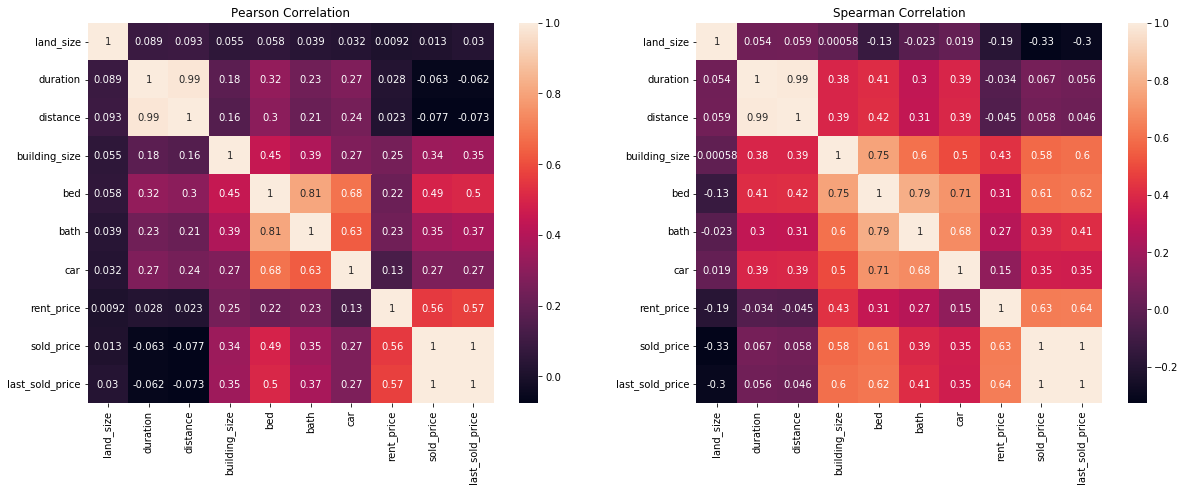

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(clean_df.corr(method='pearson'), annot=True, ax=ax1)
ax1.set_title("Pearson Correlation")
sns.heatmap(clean_df.corr(method='spearman'), annot=True, ax=ax2)
ax2.set_title("Spearman Correlation")
fig.savefig("../plots/prop_corr.png")
None

Except for land size, rent price appears to have some linear correlation with all attributes and comparatively stronger monotonic correlation.

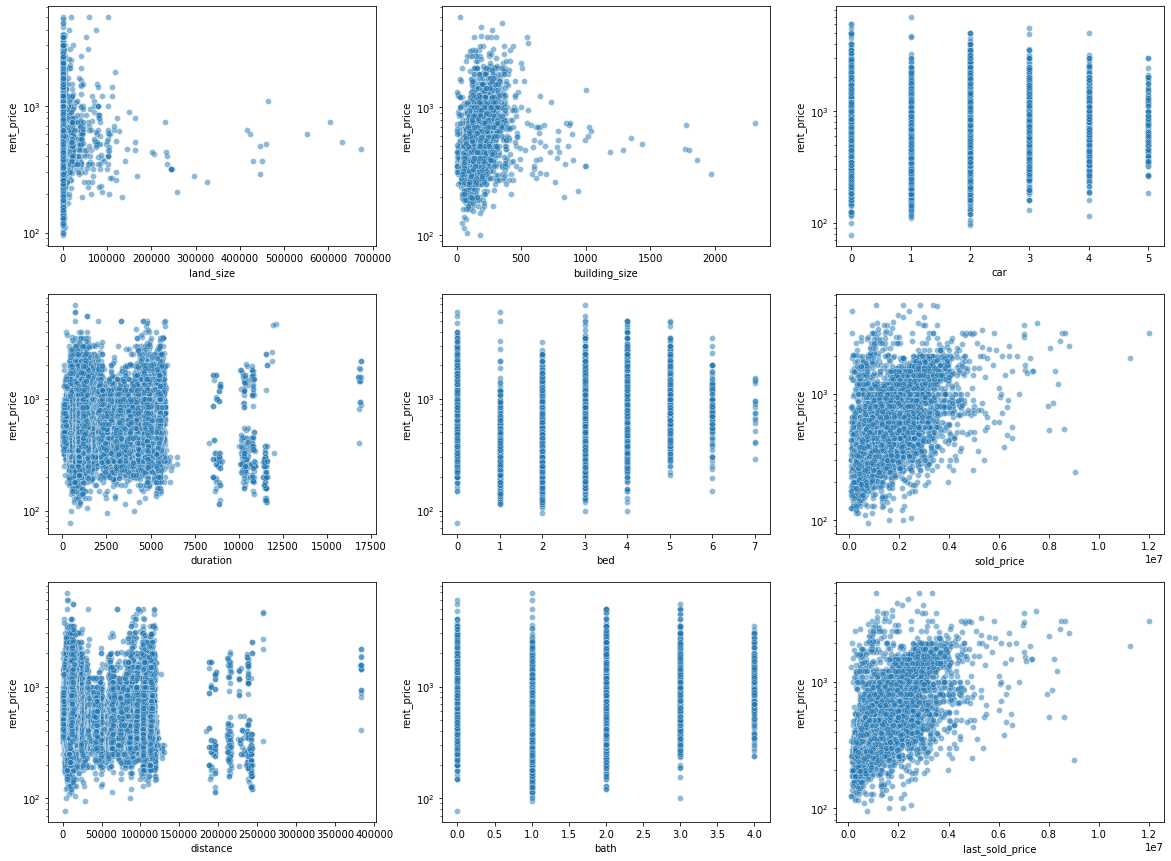

In [13]:
fig, axs = plt.subplots(3,3,figsize=(20,15))
for i, col in enumerate(clean_df.corr().columns.drop('rent_price')):
    ax = axs[i%3][i//3]
    sns.scatterplot(data=clean_df, x=col, y='rent_price', alpha=0.5, ax=ax)
    ax.set_yscale('log')
fig.savefig("../plots/prop_rent_scatter.png")

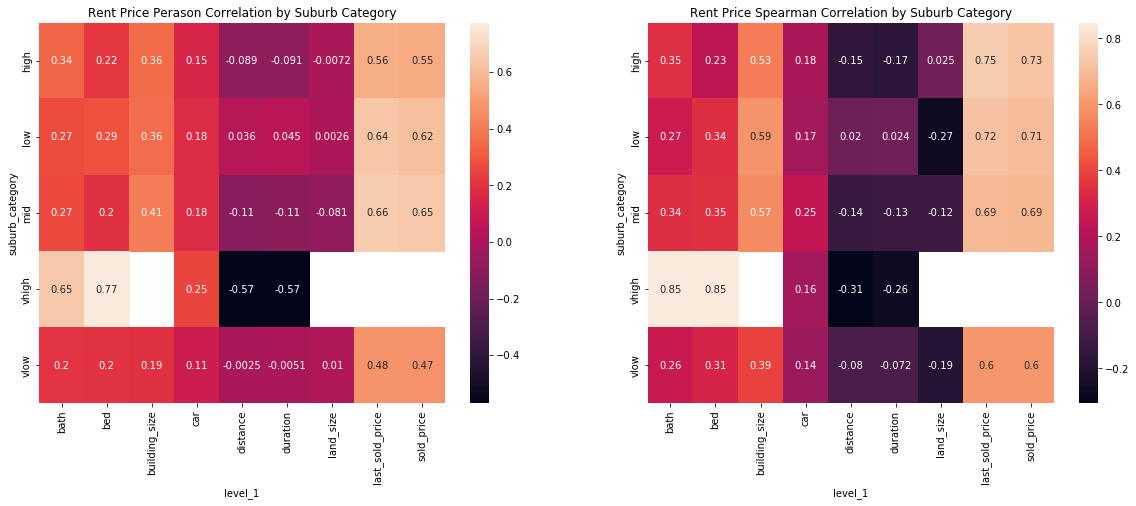

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(clean_df.groupby('suburb_category').corr(method='pearson')['rent_price'].dropna().reset_index().pivot('suburb_category','level_1','rent_price').drop('rent_price',axis=1), annot=True, ax=ax1)
ax1.set_title("Rent Price Perason Correlation by Suburb Category")
sns.heatmap(clean_df.groupby('suburb_category').corr(method='spearman')['rent_price'].dropna().reset_index().pivot('suburb_category','level_1','rent_price').drop('rent_price',axis=1), annot=True, ax=ax2)
ax2.set_title("Rent Price Spearman Correlation by Suburb Category")
fig.savefig("../plots/sub_cat_corr.png")
None

Grouping by suburb category, we observe much higher linear correlation with rent price in the lower range suburbs, which is feasible due to the exponential differences between suburb categories

# Growth

In [15]:
import statsmodels.formula.api as smf

## Population Growth (LGA)

In [16]:
popdf = pd.read_excel('../data/raw/abs_data/pop_deaths.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 129)[1:]
popdf = popdf.drop([(y, 'Standardised death rate.1') for y in range(2012, 2020)], axis=1)
popdf = popdf.drop([(y, 'Standardised death rate') for y in range(2012, 2021)], axis=1)
popdf.columns = [('LGA Code'), ('LGA Name')] + [','.join([str(c) for c in x]) for x in popdf.columns[2:]]
popdf2 = popdf.melt(id_vars=["LGA Code", "LGA Name"])
popdf2 = popdf2.dropna()
popdf2['value'] = popdf2.value.astype('int')
popdf2[['year','var']] = popdf2['variable'].str.split(',').tolist()
popdf2['year'] = popdf2['year'].astype(int)
popdf2 = popdf2.sort_values('year')
# Forecasting population
popdf3 = popdf2.loc[popdf2['var'] == 'Estimated resident population'].copy()
popdf3['growth'] = popdf3.groupby(['LGA Code', 'LGA Name'])['value'].apply(pd.Series.pct_change)

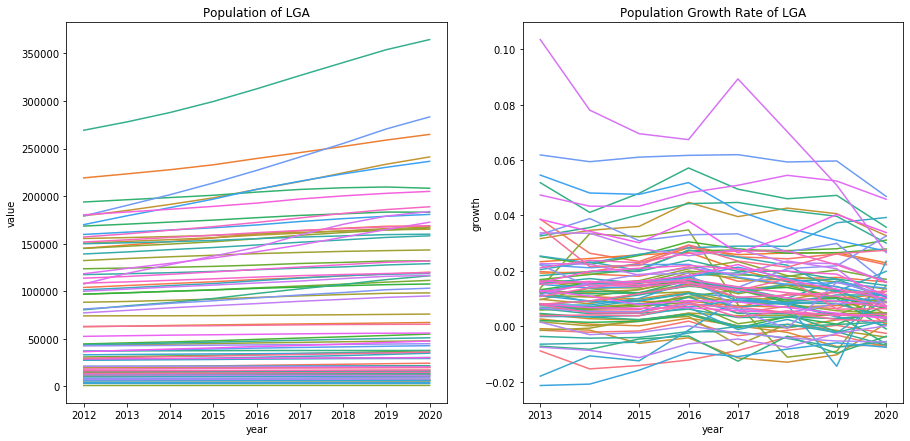

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
sns.lineplot(data=popdf3, x='year', y='value', hue='LGA Name', ax=ax1)
ax1.get_legend().remove()
ax1.set_title("Population of LGA")
sns.lineplot(data=popdf3, x='year', y='growth', hue='LGA Name', ax=ax2)
ax2.get_legend().remove()
ax2.set_title("Population Growth Rate of LGA")
fig.savefig("../plots/lga_pop.png")

In [18]:
pop_pred = pd.DataFrame()
for (name, code), d in popdf3.dropna(subset='growth').groupby(['LGA Name', 'LGA Code']):
    d = d[['year','growth']]
    mod = smf.ols(formula="growth~year", data=d).fit()
    d_forecast = pd.DataFrame({'year': list(range(2012,2029))})
    d_forecast['growth_hat'] = mod.predict(d_forecast)
    new = pd.concat([d, d_forecast])
    new['LGA Name'] = name
    new['LGA Code'] = code
    pop_pred = pd.concat([pop_pred, new]).reset_index(drop=True)

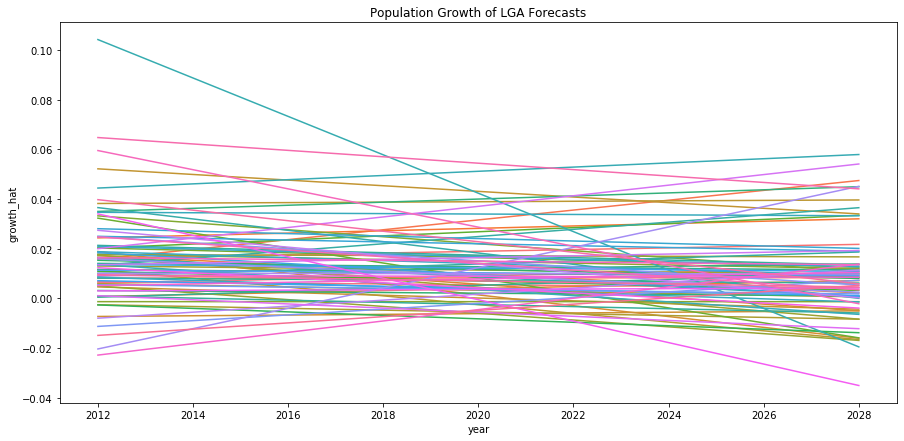

In [19]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=pop_pred, x='year', y='growth_hat', hue='LGA Name', ax=ax)
ax.get_legend().remove()
ax.set_title("Population Growth of LGA Forecasts")
fig.savefig("../plots/lga_prop_growth_forecast.png")

In [20]:
import numpy as np
def predict_forward(d):
    vs, ghs = d['value'].copy().values, d['growth_hat'].values
    max_ind = max(np.array(range(len(vs)))[d['value'].notna()])
    for i in range(max_ind, len(vs)-1):
        vs[i+1] = vs[i] * (1 + ghs[i])
    return vs

In [21]:
pop_final = popdf3.merge(pop_pred[['year','LGA Name','LGA Code','growth_hat']], on=['year','LGA Name','LGA Code'], how='outer')
pop_final_df = pd.DataFrame()
for (c,n), d in pop_final.sort_values('year').groupby(['LGA Code','LGA Name']):
    d['population'] = predict_forward(d)
    pop_final_df = pd.concat([pop_final_df, d])

/home/arajkumar/.local/lib/python3.8/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


Text(0.5, 1.0, 'Population of LGA')

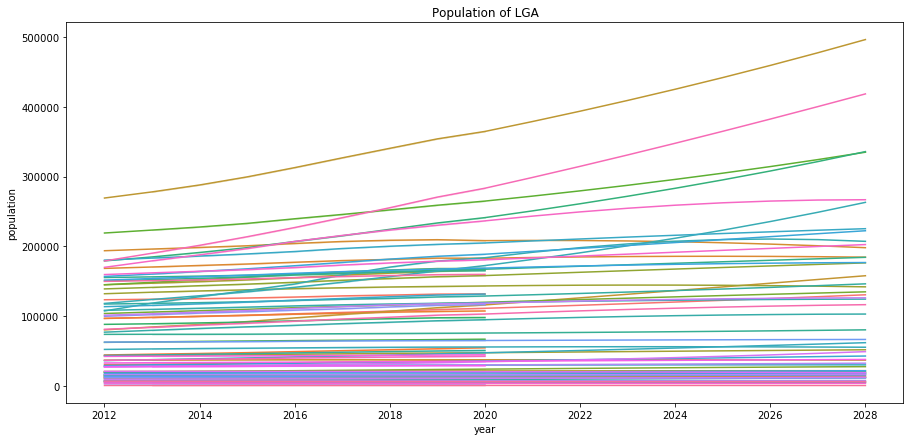

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=pop_final_df, x='year', y='population', hue='LGA Name', ax=ax)
ax.get_legend().remove()
ax.set_title("Population of LGA")

In [23]:
# pop_df.merge(popdf3, on=['year','LGA Name', 'LGA Code'])

## LGA Suburb Merge

In [24]:
# Terry -
#SAL_PATH = "../data/raw/lga_conversion/SAL_2021_AUST.csv"
#LGA_PATH = "../data/raw/lga_conversion/LGA_2021_AUST.csv"

# Arjun -
SAL_PATH = "../data/raw/SAL_2021_AUST.csv"
LGA_PATH = "../data/raw/LGA_2021_AUST.csv"

# MB_PATH = "../data/raw/lga_conversion/MB_2021_AUST.csv"
sal_df = pd.read_csv(SAL_PATH).query('STATE_NAME_2021=="Victoria"')
lga_df = pd.read_csv(LGA_PATH).query('STATE_NAME_2021=="Victoria"')
# mb_df = pd.read_csv(MB_PATH).query('STATE_NAME_2021=="Victoria"')

/tmp/ipykernel_620/868040465.py:10: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sal_df = pd.read_csv(SAL_PATH).query('STATE_NAME_2021=="Victoria"')
/tmp/ipykernel_620/868040465.py:11: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  lga_df = pd.read_csv(LGA_PATH).query('STATE_NAME_2021=="Victoria"')


In [25]:
sal_df['suburb'] = sal_df['SAL_NAME_2021'].str.replace(' \([^\(\)]+\)', '').apply(lambda x: 'Preston West' if x=='Preston' else x)

/tmp/ipykernel_620/330090671.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sal_df['suburb'] = sal_df['SAL_NAME_2021'].str.replace(' \([^\(\)]+\)', '').apply(lambda x: 'Preston West' if x=='Preston' else x)


In [26]:
pop_df2 = sal_df.merge(lga_df[['MB_CODE_2021','LGA_CODE_2021']], on='MB_CODE_2021')[[
    'SAL_NAME_2021', 'MB_CODE_2021', 'LGA_CODE_2021', 'suburb']].drop_duplicates().merge(
    pop_final_df, left_on='LGA_CODE_2021', right_on='LGA Code')

In [27]:
pop_df2

,SAL_NAME_2021,MB_CODE_2021,LGA_CODE_2021,suburb,LGA Code,LGA Name,variable,value,year,var,growth,growth_hat,population
0,Abbeyard,20688500000,20110,Abbeyard,20110.0,Alpine (S),"2012,Estimated resident population",12183.0,2012,Estimated resident population,NaN,0.006278,12183.0
1,Abbeyard,20688500000,20110,Abbeyard,20110.0,Alpine (S),"2013,Estimated resident population",12283.0,2013,Estimated resident population,0.008208,NaN,12283.0
2,Abbeyard,20688500000,20110,Abbeyard,20110.0,Alpine (S),"2013,Estimated resident population",12283.0,2013,Estimated resident population,0.008208,0.006636,12283.0
3,Abbeyard,20688500000,20110,Abbeyard,20110.0,Alpine (S),"2014,Estimated resident population",12355.0,2014,Estimated resident population,0.005862,0.006994,12355.0
4,Abbeyard,20688500000,20110,Abbeyard,20110.0,Alpine (S),"2014,Estimated resident population",12355.0,2014,Estimated resident population,0.005862,NaN,12355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218270,Swan Island,20535312000,26080,Swan Island,26080.0,Queenscliffe (B),NaN,NaN,2024,NaN,NaN,0.028770,NaN
2218271,Swan Island,20535312000,26080,Swan Island,26080.0,Queenscliffe (B),NaN,NaN,2025,NaN,NaN,0.032862,NaN
2218272,Swan Island,20535312000,26080,Swan Island,26080.0,Queenscliffe (B),NaN,NaN,2026,NaN,NaN,0.036955,NaN
2218273,Swan Island,20535312000,26080,Swan Island,26080.0,Queenscliffe (B),NaN,NaN,2027,NaN,NaN,0.041047,NaN


In [28]:
sal_df

,Unnamed: 0,MB_CODE_2021,SAL_CODE_2021,SAL_NAME_2021,STATE_CODE_2021,STATE_NAME_2021,AUS_CODE_2021,AUS_NAME_2021,AREA_ALBERS_SQKM,ASGS_LOCI_URI_2021,suburb
112738,112738,20688500000,20001,Abbeyard,2,Victoria,AUS,Australia,26.8389,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Abbeyard
112739,112739,20001851000,20001,Abbeyard,2,Victoria,AUS,Australia,300.6619,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Abbeyard
112740,112740,20642500000,20002,Abbotsford (Vic.),2,Victoria,AUS,Australia,0.0065,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Abbotsford
112741,112741,20631932110,20002,Abbotsford (Vic.),2,Victoria,AUS,Australia,0.0084,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Abbotsford
112742,112742,20638330000,20002,Abbotsford (Vic.),2,Victoria,AUS,Australia,0.0159,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Abbotsford
...,...,...,...,...,...,...,...,...,...,...,...
201472,201472,27000001777,29797,Migratory - Offshore - Shipping (Vic.),2,Victoria,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Migratory - Offshore - Shipping
201473,201473,27000002777,29797,Migratory - Offshore - Shipping (Vic.),2,Victoria,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Migratory - Offshore - Shipping
201474,201474,27000003777,29797,Migratory - Offshore - Shipping (Vic.),2,Victoria,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Migratory - Offshore - Shipping
201475,201475,28000000778,29797,Migratory - Offshore - Shipping (Vic.),2,Victoria,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/MB/2...,Migratory - Offshore - Shipping


In [29]:
lga_df['LGA_NAME_2021'].unique()

array(['Alpine', 'Ararat', 'Ballarat', 'Banyule', 'Bass Coast', 'Baw Baw',
       'Bayside (Vic.)', 'Benalla', 'Boroondara', 'Brimbank', 'Buloke',
       'Campaspe', 'Cardinia', 'Casey', 'Central Goldfields',
       'Colac Otway', 'Corangamite', 'Darebin', 'East Gippsland',
       'Frankston', 'Gannawarra', 'Glen Eira', 'Glenelg', 'Golden Plains',
       'Greater Bendigo', 'Greater Dandenong', 'Greater Geelong',
       'Greater Shepparton', 'Hepburn', 'Hindmarsh', 'Hobsons Bay',
       'Horsham', 'Hume', 'Indigo', 'Kingston (Vic.)', 'Knox',
       'Latrobe (Vic.)', 'Loddon', 'Macedon Ranges', 'Manningham',
       'Mansfield', 'Maribyrnong', 'Maroondah', 'Melbourne', 'Melton',
       'Mildura', 'Mitchell', 'Moira', 'Monash', 'Moonee Valley',
       'Moorabool', 'Moreland', 'Mornington Peninsula', 'Mount Alexander',
       'Moyne', 'Murrindindi', 'Nillumbik', 'Northern Grampians',
       'Port Phillip', 'Pyrenees', 'Queenscliffe', 'South Gippsland',
       'Southern Grampians', 'Stonning

In [30]:
clean_df[['suburb']].drop_duplicates().merge(pop_df2, on='suburb', how='left')

,suburb,SAL_NAME_2021,MB_CODE_2021,LGA_CODE_2021,LGA Code,LGA Name,variable,value,year,var,growth,growth_hat,population
0,Mentone,Mentone,20309670000,23430,23430.0,Kingston (C) (Vic.),"2012,Estimated resident population",150435.0,2012.0,Estimated resident population,NaN,0.014117,150435.000000
1,Mentone,Mentone,20309670000,23430,23430.0,Kingston (C) (Vic.),"2013,Estimated resident population",152336.0,2013.0,Estimated resident population,0.012637,NaN,152336.000000
2,Mentone,Mentone,20309670000,23430,23430.0,Kingston (C) (Vic.),"2013,Estimated resident population",152336.0,2013.0,Estimated resident population,0.012637,0.013951,152336.000000
3,Mentone,Mentone,20309670000,23430,23430.0,Kingston (C) (Vic.),"2014,Estimated resident population",154210.0,2014.0,Estimated resident population,0.012302,NaN,154210.000000
4,Mentone,Mentone,20309670000,23430,23430.0,Kingston (C) (Vic.),"2014,Estimated resident population",154210.0,2014.0,Estimated resident population,0.012302,0.013784,154210.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
591021,Mount Buller,Mount Buller,20663885000,29399,29399.0,Unincorporated Vic,NaN,NaN,2024.0,NaN,NaN,-0.017782,869.236785
591022,Mount Buller,Mount Buller,20663885000,29399,29399.0,Unincorporated Vic,NaN,NaN,2025.0,NaN,NaN,-0.022100,853.780342
591023,Mount Buller,Mount Buller,20663885000,29399,29399.0,Unincorporated Vic,NaN,NaN,2026.0,NaN,NaN,-0.026418,834.911975
591024,Mount Buller,Mount Buller,20663885000,29399,29399.0,Unincorporated Vic,NaN,NaN,2027.0,NaN,NaN,-0.030736,812.855308


In [31]:
# clean_df.to_csv('../data/curated/lga_suburb_conversion.csv')

## By suburb

In [32]:
# Duplicate columns because notebook doesn't run in order and there were too many cells in between to rearrange

clean_df['rent_year'] = clean_df['rent_date'].dt.year

def calc_growth(d):
    year, value = d['rent_year'], d['value']
    return pd.Series.pct_change(value)/year.diff()
sub_year_df = clean_df.groupby(['suburb','rent_year'])['rent_price'].mean().reset_index(name='value')
sub_year_df['growth/yr'] = sub_year_df.groupby('suburb').apply(calc_growth).values

sub_year_df = sub_year_df.merge(pop_df2[['suburb','year','growth']].drop_duplicates().rename(
    {'year':'rent_year','growth':'population'},axis=1), on=['suburb','rent_year'], how='left')#.dropna()

In [33]:
def calc_growth(d):
    year, value = d['year'], d['value']
    return pd.Series.pct_change(value)/year.diff()

In [34]:
sub = pop_df2.copy()
sub_pop = sub[['suburb', 'year', 'var', 'value']].dropna()
sub_pop['pop_growth/yr'] = sub_pop.groupby('suburb').apply(calc_growth).values
sub_pop.dropna(inplace = True)
sub_pop.drop_duplicates(inplace = True)
sub_pop = sub_pop.loc[sub_pop['suburb'].isin(sub_year_df['suburb'])]
sub_pop.drop(columns = ['var'], inplace = True)
columns = ['suburb', 'year', 'population', 'pop_growth/yr']
sub_pop.columns = columns

In [35]:
# Value + growth / year
# Have data from 2004 - 2022 for rent prices, we only have 2012 - 2020 for population data
sub_rent = sub_year_df.copy()
sub_rent = sub_rent.loc[2012 <= sub_rent['rent_year']]
sub_rent = sub_rent.loc[sub_rent['rent_year'] <= 2020]
sub_rent.drop(columns = ['population'], inplace = True)
sub_rent

# Population + growth / year
# sub_pop

# Death count + growth / year
# sub_deaths

,suburb,rent_year,value,growth/yr
7,Abbotsford,2012,900.000000,0.651376
8,Abbotsford,2013,520.000000,-0.422222
9,Abbotsford,2014,515.000000,-0.009615
10,Abbotsford,2015,586.428571,0.138696
11,Abbotsford,2016,529.375000,-0.097290
...,...,...,...,...
3580,Yarraville,2016,504.545455,0.089208
3581,Yarraville,2017,515.000000,0.020721
3582,Yarraville,2018,550.833333,0.069579
3583,Yarraville,2019,587.250000,0.066112


In [36]:
sub_deaths = popdf2.loc[popdf2['var'] == 'Deaths']
sub_deaths.drop(columns = ['variable', 'var'], inplace = True)

lga_merger = pop_df2[['LGA_CODE_2021', 'suburb']]
sub_deaths = sub_deaths.merge(lga_merger, left_on = 'LGA Code', right_on = 'LGA_CODE_2021').drop_duplicates()

sub_deaths = sub_deaths[['value', 'year', 'suburb']]
sub_deaths = sub_deaths.loc[sub_deaths['suburb'].isin(sub_year_df['suburb'])]
columns = ['deaths', 'year', 'suburb']
sub_deaths.columns = columns

/tmp/ipykernel_620/2868982050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_deaths.drop(columns = ['variable', 'var'], inplace = True)


In [45]:
# From https://datascience.stackexchange.com/questions/103836/multiple-merges-make-the-data-frame-in-pandas-to-explode-and-causing-memory-issu

from functools import reduce

#create a list that contains all your data frames to be merged
ldf = [sub_rent, sub_pop, sub_deaths]
#necessary to have a common name column to merge all the frames
df = reduce(lambda x,y: pd.merge(x,y, on = "suburb", how = "left"), ldf)
df.drop_duplicates(inplace = True)

In [46]:
df

,suburb,rent_year,value,growth/yr,year_x,population,pop_growth/yr,deaths,year_y
0,Abbotsford,2012,900.000000,0.651376,2012.0,81268.0,0.017153,337.0,2012.0
1,Abbotsford,2012,900.000000,0.651376,2012.0,81268.0,0.017153,304.0,2013.0
2,Abbotsford,2012,900.000000,0.651376,2012.0,81268.0,0.017153,355.0,2014.0
3,Abbotsford,2012,900.000000,0.651376,2012.0,81268.0,0.017153,381.0,2015.0
4,Abbotsford,2012,900.000000,0.651376,2012.0,81268.0,0.017153,395.0,2016.0
...,...,...,...,...,...,...,...,...,...
865344,Yarraville,2020,605.882353,0.031728,2012.0,77179.0,0.035167,441.0,2016.0
865345,Yarraville,2020,605.882353,0.031728,2012.0,77179.0,0.035167,483.0,2017.0
865346,Yarraville,2020,605.882353,0.031728,2012.0,77179.0,0.035167,486.0,2018.0
865347,Yarraville,2020,605.882353,0.031728,2012.0,77179.0,0.035167,512.0,2019.0


## Rent Growth

In [ ]:
clean_df['rent_year'] = clean_df['rent_date'].dt.year

In [ ]:
def calc_growth(d):
    year, value = d['rent_year'], d['value']
    return pd.Series.pct_change(value)/year.diff()
sub_year_df = clean_df.groupby(['suburb','rent_year'])['rent_price'].mean().reset_index(name='value')
sub_year_df['growth/yr'] = sub_year_df.groupby('suburb').apply(calc_growth).values

In [ ]:
sub_year_df = sub_year_df.merge(pop_df2[['suburb','year','growth']].drop_duplicates().rename(
    {'year':'rent_year','growth':'population'},axis=1), on=['suburb','rent_year'], how='left')#.dropna()

In [ ]:
top_growth = sub_year_df.groupby('suburb')['growth/yr'].mean().sort_values()
fig, ax = plt.subplots(1,1,figsize=(12,5))
top_growth.tail(10).plot.barh()
plt.title("Top 10 Suburb Avg Rent Growth")
fig.savefig("../plots/top_10_sub_growth.png")
None

In [ ]:
sub_year_df

In [ ]:
top_growth

In [ ]:
g = sns.lmplot(data=sub_year_df.loc[sub_year_df['suburb'].isin(top_growth.tail(10).index)], height=6,
             x='rent_year', y='value', hue='suburb')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=sub_year_df.loc[sub_year_df['suburb'].isin(top_growth.tail(10).index)],
            x='rent_year', y='growth/yr', hue='suburb')
ax.set_title("Top 10 Suburb Growth Rates Per Year")

## By Linear Regression

In [ ]:
top_growth = mod.params.loc[mod.params.index.str.match('^rent_year:')].sort_values()
top10growth = top_growth.tail(10).index.str.extract(r"T\.([\w\s]+)\]").values.reshape(-1)

In [ ]:
mod = smf.ols(formula="value~rent_year+C(suburb)+rent_year*C(suburb)",data=sub_year_df).fit()

In [ ]:
top_growth_lin = mod.params.loc[mod.params.index.str.match('^rent_year:')].sort_values()
top10growth = top_growth_lin.tail(10).index.str.extract(r"T\.([\w\s]+)\]").values.reshape(-1)

In [ ]:
top10growth_sub = sub_year_df.loc[sub_year_df['suburb'].isin(top10growth)].copy()
g2 = sns.lmplot(data=top10growth_sub, height=6,
             x='rent_year', y='value', hue='suburb')

In [ ]:
popdf2

In [ ]:
test = popdf2.loc[popdf2['var'] == 'Deaths']
#test['LGA Name'] = test['LGA Name'].str[:-4]

In [ ]:
test

In [ ]:
test1 = test.merge(sub, on = 'LGA Name')

In [ ]:
test1